# ASE Interface

In [1]:
import rdkit2ase

The main functionality of `rdkit2ase` is to generate new structures from SMILES.
For this purpose, you can utilize [smiles2atoms](modules.rst#rdkit2ase.smiles2atoms) and [smiles2conformers](modules.rst#rdkit2ase.smiles2conformers)

In [2]:
water = rdkit2ase.smiles2atoms("O")
water

Atoms(symbols='OH2', pbc=False)

In [3]:
aspirin = rdkit2ase.smiles2conformers("CC(=O)OC1=CC=CC=C1C(=O)O", numConfs=3)
aspirin

[Atoms(symbols='C2O2C7O2H8', pbc=False),
 Atoms(symbols='C2O2C7O2H8', pbc=False),
 Atoms(symbols='C2O2C7O2H8', pbc=False)]

Within `rdkit2ase` you can translate structures between ASE and rdkit.

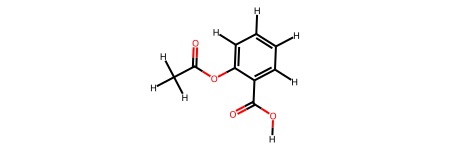

In [4]:
mol = rdkit2ase.ase2rdkit(aspirin[0])
print(mol)
mol

If a structure has been generated using `rdkit2ase` it includes `smiles` and `connectivity` in it's `atoms.info` key. This information is utilized to quickly transform `ase.Atoms` to rdkit structures.

In [5]:
aspirin[0].info

{'smiles': 'CC(=O)OC1=CC=CC=C1C(=O)O',
 'connectivity': [(0, 1, 1.0),
  (1, 2, 2.0),
  (1, 3, 1.0),
  (3, 4, 1.0),
  (4, 5, 1.5),
  (5, 6, 1.5),
  (6, 7, 1.5),
  (7, 8, 1.5),
  (8, 9, 1.5),
  (9, 10, 1.0),
  (10, 11, 2.0),
  (10, 12, 1.0),
  (9, 4, 1.5),
  (0, 13, 1.0),
  (0, 14, 1.0),
  (0, 15, 1.0),
  (5, 16, 1.0),
  (6, 17, 1.0),
  (7, 18, 1.0),
  (8, 19, 1.0),
  (12, 20, 1.0)]}

Without this information, `rdkit2ase` will try to guess the bond information. You can aid this process, by including SMILES into the `suggestions=` keyword.

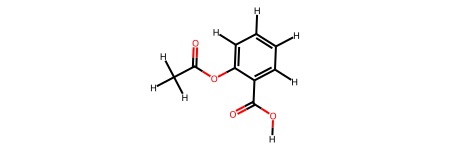

In [6]:
aspirin_0 = aspirin[0]
del aspirin_0.info["smiles"]
del aspirin_0.info["connectivity"]
rdkit2ase.ase2rdkit(aspirin_0, suggestions=[])

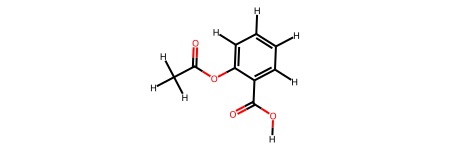

In [7]:
rdkit2ase.ase2rdkit(aspirin_0, suggestions=["CC(=O)OC1=CC=CC=C1C(=O)O"])

You can use [match_substructure](modules.rst#rdkit2ase.match_substructure) to select parts of the structure based on SMILES, SMARTS, molecules or even ase.Atoms.

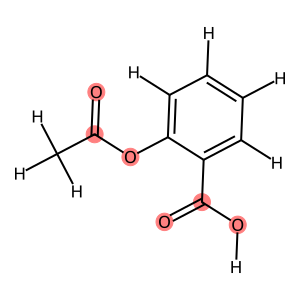

In [8]:
from rdkit.Chem import Draw

mol = rdkit2ase.ase2rdkit(aspirin_0, suggestions=["CC(=O)OC1=CC=CC=C1C(=O)O"])
Draw.MolToImage(
    mol,
    highlightAtoms={
        i
        for group in rdkit2ase.match_substructure(
            aspirin[0], smarts="C(=O)O", suggestions=[]
        )
        for i in group
    },
)

This can also be employed for periodic structures. Even if they have crossed periodic boundary conditions.

In [9]:
ethanol = rdkit2ase.smiles2conformers("CCO", numConfs=10)
box = rdkit2ase.pack([ethanol], [3], density=786, packmol="packmol.jl")

# let's move and wrap the box
box.positions += [2, 2, 2]
box.wrap()

Found 3 CH3 groups:
  CH3 group 1: atoms (0, 3, 4, 5)
  CH3 group 2: atoms (9, 12, 13, 14)
  CH3 group 3: atoms (18, 21, 22, 23)


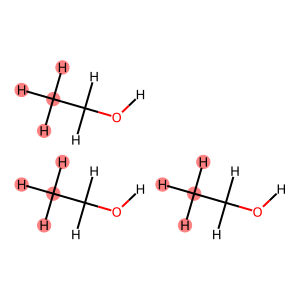

In [10]:
ch3_matches = rdkit2ase.match_substructure(box, smarts="[C]([H])([H])[H]")
print(f"Found {len(ch3_matches)} CH3 groups:")
for i, match in enumerate(ch3_matches):
    print(f"  CH3 group {i + 1}: atoms {match}")

mol = rdkit2ase.ase2rdkit(box)
Draw.MolToImage(
    mol,
    highlightAtoms={i for group in ch3_matches for i in group},
)

Hydrogen indices to highlight: {6, 7, 15, 16, 24, 25}


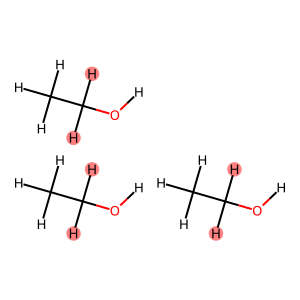

In [ ]:
# 1. Define a general SMARTS pattern to find a CH2 group next to an oxygen.
#    The pattern maps the two hydrogens as :1 and :2.
smarts_pattern = "[C;H2](-[H:1])(-[H:2])-[O]"

# 2. Perform the substructure search.
#    The result 'ch2_hydrogens' will be a list of tuples.
#    Each tuple contains indices for (Carbon, Hydrogen, Hydrogen, Oxygen).
#    Example: [(4, 5, 6, 7)]
ch2_hydrogens = rdkit2ase.match_substructure(box, smarts=smarts_pattern)

# 3. Create an empty set to store only the hydrogen indices.
highlight_indices = set()

# 4. Loop through each match found.
for match in ch2_hydrogens:
    # From each match tuple, extract the indices for the two hydrogens.
    # These are at index positions 1 and 2 because of the [H:1] and [H:2] maps.
    highlight_indices.add(match[1])
    highlight_indices.add(match[2])

# 5. Print the final set of unique hydrogen indices.
print(f"Hydrogen indices to highlight: {highlight_indices}")

# 6. Convert the ASE object to an RDKit molecule for visualization.
mol = rdkit2ase.ase2rdkit(box)

# 7. Generate an image of the molecule, highlighting only the desired atoms.
Draw.MolToImage(mol, highlightAtoms=list(highlight_indices))